In [78]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from joblib import (Parallel,
                    delayed)
from qiskit_algorithms.optimizers import SPSA

from src.Tools import portfolio_metrics
from qiskit_src.ansatz import CP_QAOA
from qiskit_src.tools import get_qubo, min_cost_partition, normalized_cost

In [79]:
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{physics}'
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

In [80]:
N_CPU_CORES = os.cpu_count()
N_CPU_CORES

8

In [81]:
def simulate(datapoint: tuple):    
    _seed_,_N_,_k_,_alpha_,_layers_,_max_iter_,_w_z_phase_,_w_next_nearest_neighbors_,_w_evenly_distributed_, _method_ = datapoint
    expected_returns, covariances = portfolio_metrics(n=_N_, seed=_seed_)

    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=_N_,
                                                                k=_k_,
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=_alpha_)
    
    max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances,
                         alpha=_alpha_,
                         lmbda=lmbda,
                         k=_k_)
    ansatz = CP_QAOA(N_qubits=_N_,
                     cardinality=_k_,
                     layers=_layers_,
                     QUBO_matrix=Q,
                     QUBO_offset=offset,
                     with_next_nearest_neighbors=_w_next_nearest_neighbors_,
                     with_evenly_distributed_start_x=_w_evenly_distributed_,
                     with_z_phase=_w_z_phase_)
    N_xx_yy_angles = _layers_ * (_N_ - 1) 
    if _w_next_nearest_neighbors_:
        N_xx_yy_angles += _layers_ * (_N_ - 2)
    if _w_z_phase_:
        N_xx_yy_angles += _N_ * _layers_
    theta_i = np.random.normal(loc=0, scale=0.1, size=N_xx_yy_angles)
    iteration_dicts = []
    if _method_ == 'SPSA':
        def spsa_callback_function(n_fun_evals, params, fun_val, stepsize, flag):
            iteration_dicts.append(ansatz.get_state_probabilities(angles=params, flip_states=False))
        spsa = SPSA(maxiter=max_iter, callback=spsa_callback_function)
        res = spsa.minimize(fun=ansatz.get_cost,x0=theta_i)
    else:
        def callback_function(x):
            iteration_dicts.append(ansatz.get_state_probabilities(angles=x, flip_states=False))
        res = sc.optimize.minimize(fun=ansatz.get_cost, x0=theta_i,
                                   method=_method_,
                                   options={'disp': False, 'maxiter': _max_iter_},
                                   callback=callback_function)
    return [normalized_cost(result=it,
                            QUBO_matrix=Q,
                            QUBO_offset=offset,
                            max_cost=max_cost, 
                            min_cost=min_cost) for it in iteration_dicts]

In [82]:
# General settings:
N=6
k=3
alpha=0.001
layers=1
max_iter=50
w_z_phase = False
w_next_nearest_neighbors = True
w_evenly_distributed = True
method_1='COBYLA'
method_2='Nelder-Mead'
method_3='SPSA'

# Number of runs:
N_SEEDS = (N_CPU_CORES-1)*10
datapoints_1, datapoints_2, datapoints_3 = [], [], []
for seed in range(N_SEEDS):
    datapoints_1.append((seed,N,k,alpha,layers,max_iter,w_z_phase,w_next_nearest_neighbors,w_evenly_distributed,method_1))
    datapoints_2.append((seed,N,k,alpha,layers,max_iter,w_z_phase,w_next_nearest_neighbors,w_evenly_distributed,method_2))
    datapoints_3.append((seed,N,k,alpha,layers,max_iter,w_z_phase,w_next_nearest_neighbors,w_evenly_distributed,method_3))

N_jobs = N_CPU_CORES-1
YS_1 = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoints_1)
YS_2 = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoints_2)
YS_3 = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoints_3)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed:    4.0s
[Parallel(

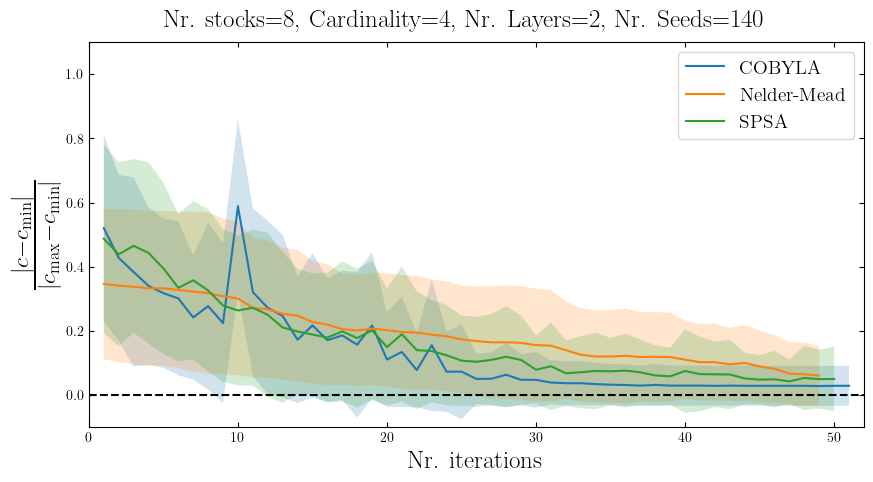

In [83]:
smallest = np.inf
for y in YS_1:
    if len(y) < smallest:
        smallest = len(y)
updated_YS_1 = []
for y in YS_1:
    updated_YS_1.append(y[:smallest])
updated_YS_1 = np.array(updated_YS_1)
Y_avg_1 = np.mean(updated_YS_1, axis=0)
Y_std_1 = np.std(updated_YS_1, axis=0)
X_1 = [it + 1 for it in range(len(Y_avg_1))]

smallest = np.inf
for y in YS_2:
    if len(y) < smallest:
        smallest = len(y)
updated_YS_2 = []
for y in YS_2:
    updated_YS_2.append(y[:smallest])
updated_YS_2 = np.array(updated_YS_2)
Y_avg_2 = np.mean(updated_YS_2, axis=0)
Y_std_2 = np.std(updated_YS_2, axis=0)
X_2 = [it + 1 for it in range(len(Y_avg_2))]

smallest = np.inf
for y in YS_3:
    if len(y) < smallest:
        smallest = len(y)
updated_YS_3 = []
for y in YS_3:
    updated_YS_3.append(y[:smallest])
updated_YS_3 = np.array(updated_YS_3)
Y_avg_3 = np.mean(updated_YS_3, axis=0)
Y_std_3 = np.std(updated_YS_3, axis=0)
X_3 = [it + 1 for it in range(len(Y_avg_3))]



fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.suptitle('Nr. stocks=8,  Cardinality=4,  Nr. Layers=2,  Nr. Seeds=140', y=0.945, fontsize=18)
ax.set_xlim(0,len(Y_avg_1)+1)
ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,len(Y_avg_1)+1,ls='--',color='k')

ax.plot(X_1, Y_avg_1, label=method_1)
ax.fill_between(X_1, Y_avg_1-Y_std_1, Y_avg_1+Y_std_1, alpha=0.2)

ax.plot(X_2, Y_avg_2, label=method_2)
ax.fill_between(X_2, Y_avg_2-Y_std_2, Y_avg_2+Y_std_2, alpha=0.2)

ax.plot(X_3, Y_avg_3, label=method_3)
ax.fill_between(X_3, Y_avg_3-Y_std_3, Y_avg_3+Y_std_3, alpha=0.2)

ax.set_xlabel('Nr. iterations', fontsize=18)
ax.set_ylabel(r'$\frac{|c-c_{\textrm{min}}|}{|c_{\textrm{max}}-c_{\textrm{min}}|}$', fontsize=24)
ax.legend(fontsize=14)

#plt.savefig('plots/optimizer_comparison.png', dpi=300)
plt.show()


[0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35,
 0.4,
 0.45000000000000007,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.85,
 0.9,
 0.9500000000000001,
 1.0]